# Propeller
* Run the scene workshop1.ttt in CoppeliaSim

In [24]:
import sim
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Check if python is connecting to Coppelia

In [29]:
sim.simxFinish(-1)  # Close opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    print('Simulation time in milliseconds: ', sim.simxGetLastCmdTime(clientID))
    
    # Get Object position
    name = 'propeller'
    err_code, cuboid = sim.simxGetObjectHandle(clientID, name, sim.simx_opmode_blocking)
    res, position = sim.simxGetObjectPosition(clientID, cuboid, -1, sim.simx_opmode_blocking)        
#     print(name, 'is at [x,y,z]=', position)
    
    
    returnCode = sim.simxSetFloatSignal(clientID,'f', 100.0,sim.simx_opmode_oneshot_wait)
#     returnCode, signalValue=sim.simxGetFloatSignal(clientID,'particleVelocity',sim.simx_opmode_oneshot_wait)
#     print(signalValue)
    
    # Now close the connection to CoppeliaSim:
    sim.simxGetPingTime(clientID)
    sim.simxFinish(clientID)
    print('Disconnected')
else:
    print('Failed connecting to remote API server')


Connected
Simulation time in milliseconds:  378703
Disconnected


# Robot

In [9]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)
    
    def get_velocity(self, relative_object=-1):
        # Get velocity relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, velocity, omega = sim.simxGetObjectVelocity(self.client_id, self.frame, sim.simx_opmode_blocking)        
        return array(velocity), array(omega)
    
    
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)
    
    def set_force(self, f, signal='f'):
        return sim.simxSetFloatSignal(clientID, signal, f, sim.simx_opmode_oneshot_wait)
        

In [11]:
# Send force to a robot
r = robot('Cuboid')  # Create an instance of our robot
r.set_force(100)

r.close_connection()  

Robot connected
Connection closed


# P-Control

In [ ]:
# Send force to a robot
r = robot('Cuboid')  # Create an instance of our robot

m = 8 + 0.1 #kg mass of the block plus the mass of the prop
g = 9.8
I = 80

log = []
while True:
    x,y,z = r.get_position()
    [vx, vy, vz], ω = r.get_velocity()
    
    ez = .5 - z
    dez = 0.1 - vz
    I += ez
    f = .1 * ez + .5 * dez + m*g
    
#     print(f, ez, dez)
    r.set_force(f)
    
    
    log.append(z)
    time.sleep(0.001)

r.close_connection()  

Robot connected


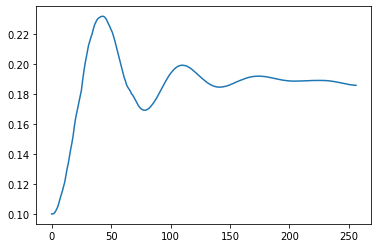

In [18]:
plot(log)

In [218]:
# Joint name in coppelia
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
r = robot('Omnirob', motor_names)  # Create an instance of our robot

# Initial locations
robot_position = r.get_position()
print('Robot position: (%.2f, %.2f) '%(robot_position[0], robot_position[1]))

desired_position = r.get_object_position('Sphere1')
print('Desired position: (%.2f, %.2f) '%(desired_position[0], desired_position[1]))

relative_position = r.get_object_relative_position('Sphere1')
print('Relative position: (%.2f, %.2f) '%(relative_position[0], relative_position[1]))

    
# Time interval
time_steps = linspace(0, 20, 100)

for t in time_steps:
    # Sensing
    robot_position = r.get_position()
    desired_position = r.get_object_position('Sphere1')
         
    # P control
    u = 100 * (desired_position - robot_position)
    
    vx, vy, vz = u
    r.send_motor_velocities([-vy - vx, vy - vx, vy + vx, -vy + vx])
    
    time.sleep(20/100)

r.send_motor_velocities([0, 0, 0, 0])
r.close_connection()  # End

Robot connected
Robot position: (7.62, 8.55) 
Desired position: (0.40, 8.05) 
Relative position: (-7.22, -0.50) 


KeyboardInterrupt: 